# 6章 ゲート付きRNN

現在では単純なRNNに代わって，LSTMやGRUと呼ばれるレイヤが使われる．LSTMやGRUには「ゲート」と呼ばれる仕組みが備わっている．ゲートによって，時系列データの長期的な依存関係を学習することができるようになる．ここでは前章のRNNの問題点を指摘し，それに代わるレイヤとしてLSTMやGRUのような「ゲート付きRNN」について仕組みを時間をかけて理解し，それが長い記憶を可能にしているメカニズムを解き明かす．

コンピュータが人間と同じように時系列を踏まえた解釈を可能にする仕組みを理解する．

## 6.1 RNNの問題点

#### なぜRNNは長期記憶を苦手とするのか

### 6.1.1 RNNの復習

#### RNNの特徴
ひとつ前の時刻の隠れ状態を利用すること．それにより過去の情報を引き継ぐことができる．

#### RNNレイヤの順伝播
行列の積と和，そして活性化関数であるtanh関数による変換から構成される．

### 6.1.2 勾配消失または勾配爆発

#### 言語モデルが行うこと
これまでに与えられた単語から次に出現する単語を予測すること．

#### 入力に対して正しい出力を行うためにある程度長期記憶ができなければ答えられないケース
多少前の情報をRNNレイヤの隠れ状態にエンコードして保持しておかなければならない．

#### RNNレイヤの学習時の役割
RNNレイヤが過去方向に意味のある勾配を伝達することによって，時間方向の依存関係を学習することができる．このとき勾配に学習すべき意味のある情報が入っており，それを過去に向かって伝達することで長期の依存関係を学習する．

#### しかし．．．
勾配が途中で弱まったり，ほとんど何の情報も持たなくなってしまうと，，シンプルなRNNレイヤでは実際にこれが起こる．勾配が小さくなる勾配消失や，逆に大きくなる勾配爆発といった問題が起きる．

### 6.1.3 勾配消失もしくは勾配爆発の原因

#### RNN時間方向だけの勾配の伝播はどのような計算が行われているか
逆伝播によって伝わる勾配としてはtanh, ＋, Matmul(行列の積)であり，＋に関しては上流から伝わる勾配をそのまま流すだけなので値に変化がない．一方，残り2つの演算であるtanhとMatMulはどう変化するか．

tahn: $y = tanh(x)$ その微分は$\frac{Δy}{Δx} = 1 - y^2$となる．

# 画像挿入

値は1.0以下となり，xが0から遠ざかるにつれてその値は小さくなる．つまり逆伝播において勾配がtanhノードを通るたびに，値がどんどん小さくなってしまう！

#### 活性化関数をReLUに変更
ReLUの出力はx(0, max)なので，xが0以上なら逆伝播では上流の勾配をそのまま流すことになり，勾配の劣化が起こらない．

#### MatMulノード
$dhW^T_{h}$による行列の積によって勾配が計算される．この行列の積の計算では毎回同じ重みである$W_h$が使われる．

Duplicate key in file WindowsPath('C:/Users/81804/anaconda3/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 258 ('font.family:  sans-serif')
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


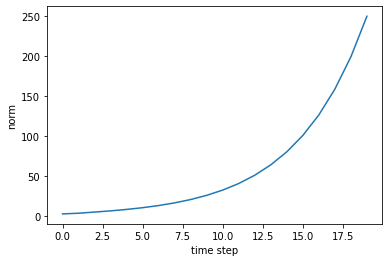

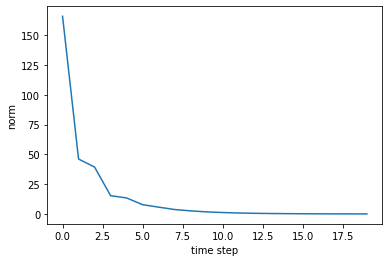

In [1]:
# MatMulによる勾配爆発，勾配消失を確認する
import numpy as np
import matplotlib.pyplot as plt

# ミニバッチサイズ，隠れ状態ベクトルの次元数，時系列データの長さ
N, H, T = 2, 3, 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list_bakuhatu = []
norm_list_shoshitu = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list_bakuhatu.append(norm)
    
Wh = np.random.randn(H, H) * 0.5
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list_shoshitu.append(norm)
    
X = np.arange(0, 20)
plt.plot(X, norm_list_bakuhatu)
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

plt.plot(X, norm_list_shoshitu)
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

#### なぜ勾配の大きさが指数的に増加もしくは減少するのか
行列WhをT回繰り返して乗算しているから．スカラなら解釈が簡単だが，今回は行列．行列の場合は「特異値」が指標になる．複数ある特異値の中でその最大値が1より大きいかどうかで，勾配の大きさの変化（増加か減少か）を予測することができる．

### 6.1.4 勾配爆発への対策

#### 勾配クリッピング
勾配爆発への対策として定番の手法．

$$
if  ||g|| >= threshold:
    g = \frac{threshold}{||g||}g
$$

g: ニューラルネットワークで使われるすべてのパラメータに対する勾配を一つにまとめる．

threshold（閾値）を超えた場合に，勾配を修正する．単純なアルゴリズムだが，大概の場合これで勾配爆発の対策はうまくいく．

## 6.2 勾配消失とLSTM

#### ゲート付きRNN
RNNの学習における勾配消失問題を解決するには，RNNレイヤのアーキテクチャを根本から変える必要がある．ゲート付きRNNには多くのアーキテクチャがある．代表格としてLSTMとGRUがある．本節ではLSTMに焦点を絞って理解する．

### 6.2.1 LSTMのインタフェース

#### 記憶セル(セル)
LSTM専用の記憶セル．LSTMレイヤ内だけでデータの受け渡しを行う点が特徴．

#### 出力側から見ると
LSTMの出力の隠れ状態ベクトルのhだけになる．記憶セルcは外部に見えない．またその存在を考える必要もない．

### 6.2.2 LSTMレイヤの組み立て

#### 記憶セル$c_t$
$c_t$には$時刻_t$におけるLSTMの記憶が格納されており，これに過去から$時刻_t$までにおいて必要な情報がすべて格納されていると考えられる．必要な情報が詰まった記憶を元に外部のレイヤへ隠れ状態$h_t$を出力．ここで行う計算は，記憶セルをtanh関数で変換する．

#### 現在の記憶セル$c_t$
$(c_{t-1}, h_{t-1}, x_t)$から「何らかの計算」によって求められる．

#### ポイント
更新された$c_t$を使って，隠れ状態の$h_t$が計算されること．

#### 数式
### $$
h_t = tanh(c_t)
$$
意味：$c_t$の各要素に対してtanh関数を適用する．要素ごとにtanh関数を適用するということはすなわち，記憶セル$c_t$と隠れ状態$h_t$の要素数が同じであることを意味する．例えば記憶セル$c_t$の要素数が100なら，状態$h_t$の要素数も100．

#### LSTMで使用するゲート
「開く・閉じる」の二択ではなく，どれだけゲートを開くか，そしてそれによってどのくらいの量の水を次に流すかをコントロールする．ゲートの開き具合は0.0～1.0の実数で表され，この開き具合もデータから自動的に学ばせる．ゲートの開き具合を求めるにあたっては，sigmoid関数を使用．（sigmoidの出力は0.0～1.0）

### 6.2.3 outputゲート

#### outputゲート
$tanh(c_t)$の各要素に対して「それらが次時刻の隠れ状態としてどれだけ重要か」ということを調整する．

#### 出力ゲートの数式
### $$
o = \sigma(x_tW_x^{(o)} + h_{t-1}W_h^{(o)} + b^{(o)})
$$

#### 最後にこの$o$と$tanh(c_t)$の要素ごとの積を$h_t$として出力する

#### アダマール積
要素ごとの積

#### アダマール積の数式
$$
h_t = o⦿tanh(c_t)
$$

#### 活性化関数の使い分け
tanhの出力は-1.0～1.0の実数．ここには何らかのエンコードされた「情報」に対する強弱（度合い）が表されていると解釈できる．sigmoidの出力は0.0～1.0の実数．これは，データをどれだけ通すかという割合を表す．よってゲートではsigmoid関数，実質的な「情報」を持つデータにはtanh関数が活性化関数として使われる．

### 6.2.4 forgetゲート

#### 忘却はよりよき前進を生む
次にやるべきことは記憶セルに対して「何を忘れるか」を明示的に指示すること．これはゲートを使って行われる．
#### forgetゲート
不要な記憶を忘れるためのゲート．
#### forgetゲートの数式
出力fを求める
### $$
f = \sigma(x_tW_x^{(f)} + h_{t-1}W_h^{(f)} + b^{(f)})
$$

#### fと$c_{t-1}$との要素ごとの積によって$c_t$を求める

### 6.2.5 新しい記憶セル

#### 新しい情報の追加
tanhノードを使用して新しい情報を記憶セルに追加する．そのため活性化関数はsigmoidではなく，tanh関数が使われる．
#### 新しい情報を記憶セルに追加するためのtanhノードの数式
### $$
g = tanh(x_tW_x^{(g)} + h_{t-1}W_h^{(g)} + b^{(g)})
$$

##### 求めたg（新しい記憶）を$c_{t-1}$に加算して新しい記憶が生まれる

### 6.2.6 inputゲート

#### 新たに追加する情報の価値を判断する
inputゲートによって，何も考えずに新しい情報を追加するのではなく，追加する情報の取捨選択を行う．inputゲートによって重みづけされた情報が新たに追加されることになる．
#### iとgの要素ごとの積の結果が記憶セルに追加される．iを求める数式
### $$
i = \sigma(x_tW_x^{(i)} + h_{t-1}W_h^{(i)} + b^{(i)})
$$

##### LSTMにはいくつかの亜種があり，他にもゲートのつなぎ方の点で（若干）異なるレイヤも見受けられる．

### 6.2.7 LSTMの勾配の流れ

#### なぜLSTMが勾配を起こさないのか．
記憶セルに着目すると逆伝播が通るのは，＋，×ノードのみ．＋は上流の勾配を流すだけ．
#### ×ノードは行列の積ではない！
ここで行われる行列の積はアダマール積であり，以前のRNNが同じ重みの行列を使って行列の積を繰り返していたのに対して，今回のLSTMに関しては毎時刻異なるゲート値によって要素ごとの積が行われる．（forgetゲートによるコントロール）
#### LSTM（Long short-term momory）
forgetゲートが忘れるべきと判断した記憶セルの要素に対しては，その勾配の要素は小さくなり．忘れてはいけないと判断した勾配の要素は劣化せずに過去方向へ伝達される．これによって記憶セルの勾配は長期にわたって記憶しておくべき情報に対して勾配消失を起こさずに伝播することができる．

## 6.3 LSTMの実装

#### 4つのAffine変換を一つに
###### LSTMで行う計算
$$
f = \sigma(x_tW_x^{(f)} + h_{t-1}W_h^{(f)} + b^{(f)}
$$
$$
g = tanh(x_tW_x^{(g)} + h_{t-1}W_h^{(g)} + b^{(g)})
$$
$$
i = \sigma(x_tW_x^{(i)} + h_{t-1}W_h^{(i)} + b^{(i)})
$$
$$
o = \sigma(x_tW_x^{(o)} + h_{t-1}W_h^{(o)} + b^{(o)})
$$
$$
c_t = f⦿c_{t-1} + g⦿i
$$
$$
h_t = o⦿tanh(c_t)
$$

#### 4つの重みをまとめ，1回のAffine変換で4つの計算を行う
$$
xt[W_x^{(f)} W_x^{(g)} W_x^{(i)} W_x^{(o)}] + h_{t-1}[W_h^{(f)} W_h^{(g)} W_h^{(i)} W_h^{(o)}] + [b^{(f)} b^{(g)} b^{(i)} b^{(o)}]
$$
##### 簡略化すると．．．
$$
x_tW_x + h_{t-1}W_h + b
$$

#### sliceノード
まとめて行った4つのAffine変換の結果を取り出す．sliceノードの後は，活性化関数(sigmoid or tanh)を通り，計算を行う．

#### sliceノードの逆伝播
sliceノードでは，行列を4分割して分配したので，逆伝播では4つの勾配を結合する必要がある．

### 6.3.1 TimeLSTMの実装

#### TimeLSTM
T個分の時系列データをまとめて処理するレイヤ

## 6.4 LSTMを使った言語モデル

#### 言語モデルの作成
TimeRNNレイヤをTimeLSTMレイヤを使用する．

## 6.5 RNNLMのさらなる改善

### 6.5.1 LSTMレイヤの多層化

### ハイパーパラメータの問題
LSTMレイヤをディープにすること，つまりレイヤを何層も重ねることは多くの場合有効．重ねる総数はハイパーパラメータなので，取り組む問題の複雑さや用意された学習データの量に応じて適宜決める必要がある．PTBデータセットの言語モデルの場合は，LSTMレイヤは2～4層程度が良い結果が得られるとされている．

#### Google翻訳で使われるGNMT
LSTMを8層重ねたネットワークで構成される．取り組む問題が複雑で，学習データが大量に用意できるなら，LSTMレイヤをディープにすることで精度向上が期待できる．

### 6.5.2 Dropoutによる過学習の抑制

#### とりわけRNNは．．．
RNNは通常のフィードフォワードなネットワークよりも簡単に過学習を起こす．

#### 過学習
訓練データに対してだけ学習しすぎてしまう状態．汎用能力が欠如した状態．汎用能力の高いモデルを構築するには訓練データの評価と検証データの評価の差から，過学習を起こしていないかを判断し，モデルの設計を行う必要がある．

#### 過学習を抑制するには
まずは

- 訓練データを増やす
- モデルの複雑さを減らす

モデルの複雑さにペナルティを与える正則化も有効．

#### Dropout
訓練時にレイヤ内のニューロンをいくつかランダムに無視して学習するのは一種の正則化である．

#### 時系列方向にDropoutを入れると．．．
学習時に時間が進むにつれて情報が失われる．時間軸方向へのDropoutはやめたほうがいい．

#### 正解は深さ方向にDropoutを組み込むこと

#### 変分Dropout
時間方向へのDropout適用に成功．時間軸方向における共通の階層にあるDropoutでは共通のマスクを利用する．これはすなわち情報の失われ方を固定化することを意味する．よって指数関数的な情報の損失を避ける．

### 6.5.3 重み共有

#### 重み共有(weight tying)
重みを結びつける．例としてEmbeddingレイヤとsoftmaxの前のAffineレイヤで重みを共有する．Embeddingレイヤの重みとAffineレイヤの重みを結びつける（共有する）テクニックが重み共有．2つのレイヤで重みを共有することで，学習するパラメータを大きく減らすことができる．さらに精度は向上する．

### 6.5.4 より良いRNNLMの実装

#### 3つの改善
- Time LSTMレイヤを2つ重ねる
- TimeDropoutレイヤを用いる
- Time EmbeddingレイヤとTime Affineレイヤで重みを共有する

#### さらなる工夫
エポックごとに検証データでパープレキシティを評価し，その値が悪くなった場合にのみ学習係数を下げる．これは実践的に良く用いられ多くの場合に良い結果が得られる．

### 6.5.5 最先端の研究へ

#### 共通点
ここまで実装した内容と最先端のモデルのアーキテクチャとの間では，精度こそまだまだ開きがあるものの，多層LSTMを使用していたり，Dropoutベースの正則化が行われていたり，重み共有が行われるなど共通点が多い．最先端のモデルはハイパーパラメータのチューニングもかなり厳密に行われている．

## 6.6 まとめ

#### 本章で学んだこと
- 単純なRNNの学習では，勾配消失・勾配爆発が問題になる
- 勾配爆発には勾配クリッピング，勾配消失にはLSTMやGRUなどのゲート付きRNNが有効である
- LSTMには，inputゲート，forgetゲート，outputゲートの3つのゲートがある
- ゲートには専用の重みがあり，sigmoid関数を使って0.0から1.0までの実装を出力する
- 言語モデルの改善には，LSTMレイヤの多層化．Dropout，重み共有などのテクニックが有効である
- RNNの正則化は重要なテーマであり，Dropoutベースのさまざまな手法が提案されている